In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U gdown  # only needed once

import gdown

file_id = '1WWj6w7vfVJOVoNp_IxVogShzCJ_dozUS'
output = 'complaints.csv' # e.g., 'complaints.csv', 'dataset.xlsx'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=1WWj6w7vfVJOVoNp_IxVogShzCJ_dozUS
From (redirected): https://drive.google.com/uc?id=1WWj6w7vfVJOVoNp_IxVogShzCJ_dozUS&confirm=t&uuid=ebd07c4d-557d-42bf-93f0-c0652138a161
To: /content/complaints.csv
100%|██████████| 6.04G/6.04G [01:00<00:00, 100MB/s] 


'complaints.csv'

In [3]:
# Install any extras you don't yet have (FAISS not needed for EDA itself)
!pip -q install pyyaml

import pathlib, gc, statistics as stats
import numpy as np, pandas as pd, matplotlib.pyplot as plt

RAW_CSV   = pathlib.Path("/content/complaints.csv")   # 👈 raw 6 GB file i just gdown-ed
FIGS_DIR  = pathlib.Path("/content/figs_raw"); FIGS_DIR.mkdir(exist_ok=True)

CHUNK_SIZE = 1_000_000      # rows per batch; drop to 500 k if RAM is tight


In [10]:
product_counts  = {}          # complaints per 'Product'
word_lengths    = []          # word-count for every non-empty narrative
with_narr       = 0           # # rows that have a narrative
without_narr    = 0           # # rows that DON'T

reader = pd.read_csv(
    RAW_CSV,
    usecols=["Product", "Consumer complaint narrative"],
    chunksize=CHUNK_SIZE,
    low_memory=False
)




In [13]:


for i, chunk in enumerate(reader, 1):
    # --- product distribution ---
    vc = chunk["Product"].value_counts(dropna=False)
    for label, n in vc.items():                       # accumulate counts
        product_counts[label] = product_counts.get(label, 0) + int(n)

    # --- narrative presence + length ---
    narr = chunk["Consumer complaint narrative"]
    non_empty = narr.notna() & (narr.str.strip() != "")
    with_narr    += int(non_empty.sum())
    without_narr += int((~non_empty).sum())
    word_lengths += narr[non_empty].str.split().str.len().tolist()

    print(f"streamed {i*CHUNK_SIZE:,} rows", end="\r")

del reader, chunk; gc.collect()
print("\n✅ finished raw-data scan")


streamed 10,000,000 rows
✅ finished raw-data scan


Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease           

/tmp/ipython-input-14-2539584269.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.title("Complaints by Product – full raw file"); plt.tight_layout()


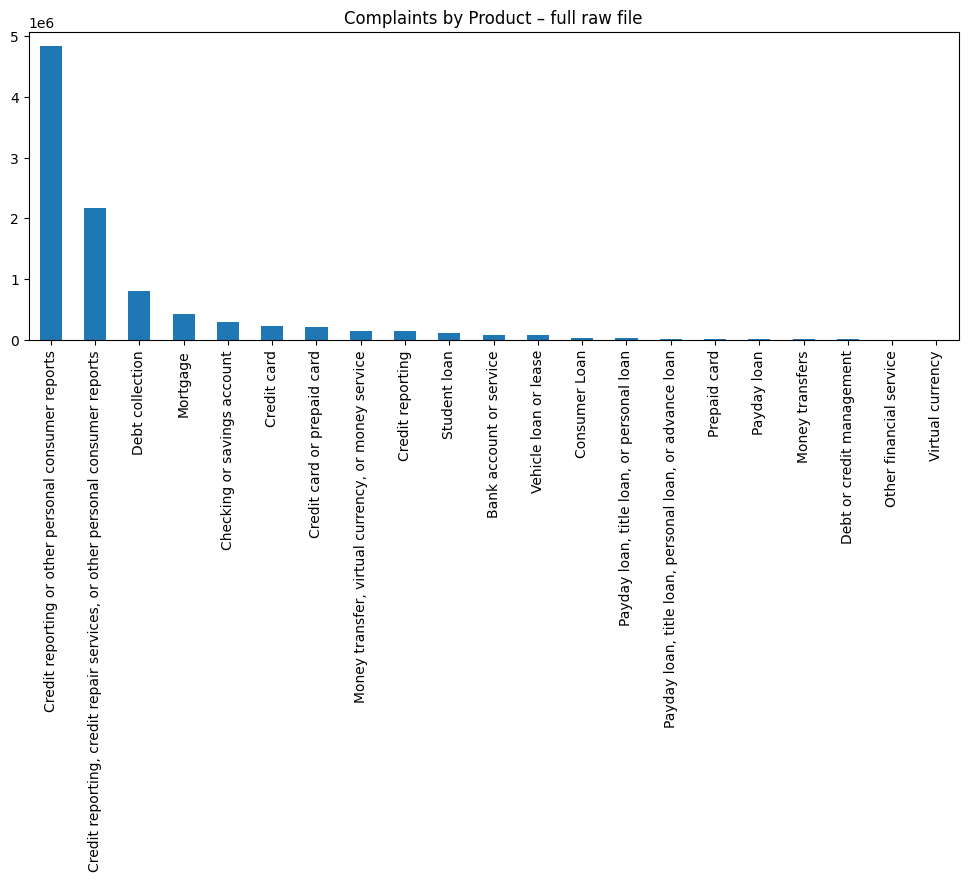

In [14]:


# counts is a dict built while streaming
prod_ser = pd.Series(product_counts).sort_values(ascending=False)
print(prod_ser.head(15))          # top-15 as a table
prod_ser.plot(kind="bar", figsize=(12,4))
plt.title("Complaints by Product – full raw file"); plt.tight_layout()
plt.savefig(FIGS_DIR / "product_distribution_raw.png"); plt.show()


Key Observations:
Dominant Category:

Credit reporting or other personal consumer reports has an overwhelming number of complaints (over 3 million), dominating the dataset.

Other Notable Categories:

Debt collection, Checking or savings account, and Credit card have relatively high complaint counts.

Products like Money transfers, Payday loan, Consumer loan, etc., have far fewer complaints but are still relevant for analysis.

Long Tail Distribution:

Most product types have very few complaints, indicating a heavy-tailed distribution.



  0-pct :     1 words
 25-pct :    59 words
 50-pct :   114 words
 75-pct :   209 words
 90-pct :   364 words
 95-pct :   519 words
 99-pct :  1021 words
100-pct :  6469 words


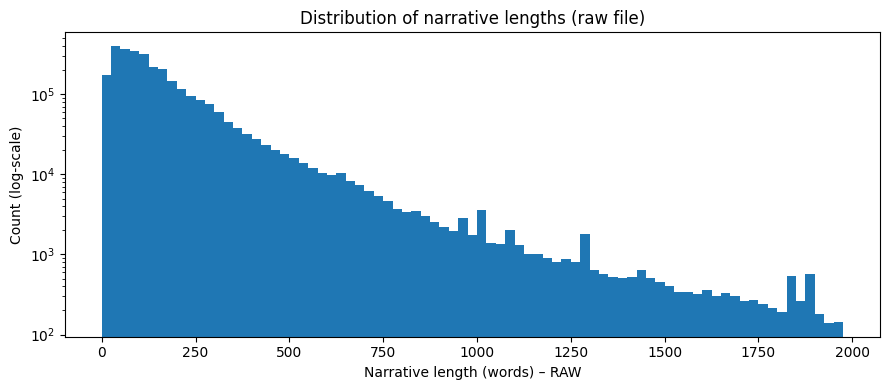

In [15]:
arr = np.asarray(word_lengths)          # word_lengths captured during streaming

# numeric table
quantiles = [0,25,50,75,90,95,99,100]
for q in quantiles:
    print(f"{q:>3}-pct : {np.percentile(arr,q):5.0f} words")

# histogram
plt.figure(figsize=(9,4))
plt.hist(arr, bins=np.arange(0, 2000, 25))
plt.yscale("log")
plt.xlabel("Narrative length (words) – RAW"); plt.ylabel("Count (log-scale)")
plt.title("Distribution of narrative lengths (raw file)")
plt.tight_layout(); plt.savefig(FIGS_DIR/"narrative_lengths_raw.png"); plt.show()


Consumer Complaint Narrative Length Distribution
To better understand the structure of the complaint narratives, we analyzed the distribution of word counts across all complaint texts. Below is a summary of key percentile statistics:

Percentile	Word Count
0% (Min)	1 word
25%	58 words
50% (Median)	107 words
75%	203 words
90%	349 words
95%	481 words
99%	912 words
100% (Max)	6469 words

Interpretation:
Very Short Narratives (≤ 58 words): Around 25% of complaints are extremely short. These may lack sufficient context for meaningful embedding or semantic search and might be filtered out or weighted differently.

Typical Complaints (~107 words): The median word count is 107, indicating that most complaints contain enough descriptive detail to be useful for chunking and analysis.

Long Complaints (> 350 words): About 10% of complaints are quite lengthy, which supports the need for text chunking before embedding. Directly embedding long texts without chunking may dilute key context.

Extremely Long Complaints (> 900 words): The top 1% of complaints are exceptionally long, with some up to 6469 words. These should be split into multiple manageable chunks (e.g., 200–300 words each) to avoid LLM context window issues.

Implications for Chunking Strategy:
This analysis supports using a chunking method (e.g., via LangChain's RecursiveCharacterTextSplitter) with a chunk size of around 150–300 words, possibly with overlap to preserve context continuity between chunks.

In [16]:


# — outputs —
total = with_narr+without_narr
print(f"\nTotal:{total:,}  with text:{with_narr:,}  ({with_narr/total:.1%})")





Total:9,609,797  with text:2,980,756  (31.0%)


In [17]:
total = with_narr + without_narr          # tallied during streaming
print(f"Total rows            : {total:,}")
print(f"With narrative        : {with_narr:,}  ({with_narr/total:.1%})")
print(f"Without / empty text  : {without_narr:,}  ({without_narr/total:.1%})")


Total rows            : 9,609,797
With narrative        : 2,980,756  (31.0%)
Without / empty text  : 6,629,041  (69.0%)


In [18]:
# ── CONFIG ──────────────────────────────────────────────────────────────
import pathlib, pandas as pd, gc, os


FILTERED_CSV  = pathlib.Path("data/complaints_filtered.csv")     # output
FILTERED_CSV.parent.mkdir(exist_ok=True, parents=True)           # ensure /data exists
CHUNK_SIZE    = 1_000_000

# IMPORTANT — spellings must match the Product column exactly as it appears
TARGET_PRODUCTS = [
    # CREDIT CARD
    "Credit card",
    "Credit card or prepaid card",

    # PERSONAL LOAN
    "Personal loan",
    "Payday loan, title loan, or personal loan",

    # BUY NOW, PAY LATER (BNPL)
    "Buy Now, Pay Later",

    # SAVINGS ACCOUNT
    "Savings account",
    "Checking or savings account",

    # MONEY TRANSFERS
    "Money transfers",
    "Money transfer, virtual currency, or money service"
]




In [19]:

# start fresh each run
if FILTERED_CSV.exists():
    FILTERED_CSV.unlink()

reader = pd.read_csv(
    RAW_CSV,
    chunksize=CHUNK_SIZE,
    low_memory=False
)

header_written = False
for i, chunk in enumerate(reader, 1):
    # keep only target products
    mask_prod = chunk["Product"].isin(TARGET_PRODUCTS)
    if not mask_prod.any():
        continue

    # drop rows with empty or NaN narrative
    narr = chunk["Consumer complaint narrative"]
    mask_narr = narr.notna() & (narr.str.strip() != "")

    filtered = chunk[mask_prod & mask_narr]
    if filtered.empty:
        continue

    #  basic lowercase / whitespace-collapse clean
    filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")

    filtered.to_csv(
        FILTERED_CSV,
        mode="a",
        index=False,
        header=not header_written
    )
    header_written = True
    print(f"✓ wrote chunk {i}  (total rows so far: {os.path.getsize(FILTERED_CSV)//1_048_576} MB)", end="\r")

del reader, chunk; gc.collect()
print(f"\n Done. Clean file saved → {FILTERED_CSV}")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


/tmp/ipython-input-19-1752032010.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Consumer complaint narrative"] = filtered["Consumer complaint narrative"].str.lower().str.split().str.join(" ")


✓ wrote chunk 10  (total rows so far: 600 MB)
 Done. Clean file saved → data/complaints_filtered.csv


In [20]:
# clean_filtered.py  – run after complaints_filtered.csv exists
import re, pathlib, pandas as pd, gc, os

IN_CSV   = pathlib.Path("data/complaints_filtered.csv")
OUT_CSV  = pathlib.Path("data/complaints_clean.csv")
CHUNK    = 500_000           # half-million rows ≈ 50-70 MB RAM

OUT_CSV.unlink(missing_ok=True)         # start fresh

# 1  compile regexes only once
BOILER_PATTERNS = [
    r"i am writing to file a complaint",
    r"to whom it may concern",
    r"dear sir or madam",
    r"please help me resolve",
    r"thank you for your time"
]
boiler_re  = re.compile("|".join(BOILER_PATTERNS), re.IGNORECASE)
special_re = re.compile(r"[^a-z0-9.,!? \n]")       # keep letters/digits/.,!?
multi_ws   = re.compile(r"\s+")

def clean(text: str) -> str:
    text = text.lower()
    text = boiler_re.sub(" ", text)      # strip boiler-plate
    text = text.replace("&amp;", "&")    # html entity
    text = special_re.sub(" ", text)     # drop everything else
    text = multi_ws.sub(" ", text)       # collapse whitespace
    return text.strip()

# 2 stream-read / write
reader = pd.read_csv(IN_CSV,

                     chunksize=CHUNK)

header = True
for i, chunk in enumerate(reader, 1):
    chunk["Consumer complaint narrative"] = chunk["Consumer complaint narrative"].apply(clean)
    chunk.to_csv(OUT_CSV, mode="a", index=False, header=header)
    header = False
    print(f" cleaned chunk {i}  (file {OUT_CSV.stat().st_size//1_048_576} MB)", end="\r")

del reader, chunk ; gc.collect()
print(f"\n  Deep-cleaned complaints saved → {OUT_CSV}")


 cleaned chunk 1  (file 595 MB)
  Deep-cleaned complaints saved → data/complaints_clean.csv
